## Kaggle Predict Future Sales

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [2]:
test = pd.read_csv('./Datasets/test.csv')
item_categories = pd.read_csv('./Datasets/item_categories.csv')
items = pd.read_csv('./Datasets/items.csv')
shops = pd.read_csv('./Datasets/shops.csv')
sales = pd.read_csv('./Datasets/sales_train.csv', parse_dates=['date'])

### Destruct category name into type and subtype and encode it 

In [3]:
from sklearn.preprocessing import LabelEncoder
item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

### Extract city from shop name and encode it

In [4]:
from sklearn.preprocessing import LabelEncoder
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0].replace('!',''))
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

### Form training data by combining different files

In [5]:
train = sales.merge(items, on="item_id").merge(shops, on="shop_id").merge(item_categories, on="item_category_id")
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,city_code,type_code,subtype_code
0,2013-02-01,0,59,22154,999.00,1.00,ЯВЛЕНИЕ 2012 (BD),37,30,11,1
1,2013-04-26,3,59,944,150.00,1.00,2012 (BD),37,30,11,1
2,2013-06-26,5,59,944,199.50,1.00,2012 (BD),37,30,11,1
3,2013-07-20,6,59,944,199.50,1.00,2012 (BD),37,30,11,1
4,2013-09-14,8,59,944,299.00,2.00,2012 (BD),37,30,11,1


Filter invalid values and item name

In [6]:
train = train.query('item_price >= 0 and item_cnt_day >= 0')
train = train.select_dtypes(exclude=['object'])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_code,type_code,subtype_code
0,2013-02-01,0,59,22154,999.00,1.00,37,30,11,1
1,2013-04-26,3,59,944,150.00,1.00,37,30,11,1
2,2013-06-26,5,59,944,199.50,1.00,37,30,11,1
3,2013-07-20,6,59,944,199.50,1.00,37,30,11,1
4,2013-09-14,8,59,944,299.00,2.00,37,30,11,1


### Feature Engineering

Construct new features by computing Item's mean and total price along with the number of item's sold mean and sum value for every item in a shop during a particular month for item type

In [7]:
train_monthly = train.sort_values('date').groupby(
    ['date_block_num', 'shop_id', 'item_id', 'city_code', 'type_code', 'subtype_code'],
    as_index=False)

train_monthly_agg = train_monthly.agg({
    'item_price':['sum', 'mean'],
    'item_cnt_day':['sum', 'mean']
})

train_monthly_agg.columns = [
                         'date_block_num', 
                         'shop_id',
                         'item_id', 
                         'city_code', 
                         'type_code', 
                         'subtype_code',
                         'item_price',
                         'mean_item_price',
                         'item_cnt',
                         'mean_item_cnt',
                         #'transactions'
                        ]

train_monthly_agg.reset_index(inplace=True)
train_monthly_agg['year'] = train_monthly_agg['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly_agg['month'] = train_monthly_agg['date_block_num'].apply(lambda x: (x % 12))

train_monthly_agg

,index,date_block_num,shop_id,item_id,city_code,type_code,subtype_code,item_price,mean_item_price,item_cnt,mean_item_cnt,year,month
0,0,0,0,32,29,11,4,884.00,221.00,6.00,1.50,2013,0
1,1,0,0,33,29,11,1,1041.00,347.00,3.00,1.00,2013,0
2,2,0,0,35,29,11,4,247.00,247.00,1.00,1.00,2013,0
3,3,0,0,43,29,11,4,221.00,221.00,1.00,1.00,2013,0
4,4,0,0,51,29,13,8,257.00,128.50,2.00,1.00,2013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608221,1608221,33,59,22087,30,19,64,357.00,119.00,6.00,2.00,2015,9
1608222,1608222,33,59,22088,30,19,64,238.00,119.00,2.00,1.00,2015,9
1608223,1608223,33,59,22091,30,19,64,179.00,179.00,1.00,1.00,2015,9
1608224,1608224,33,59,22100,30,12,19,629.00,629.00,1.00,1.00,2015,9


### Observe outliers and remove them

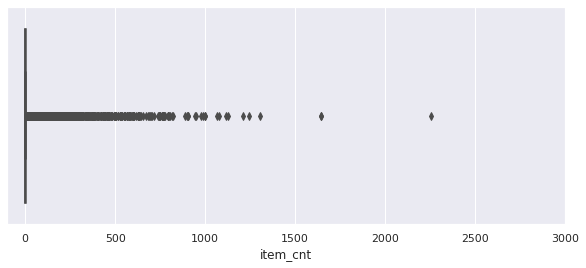

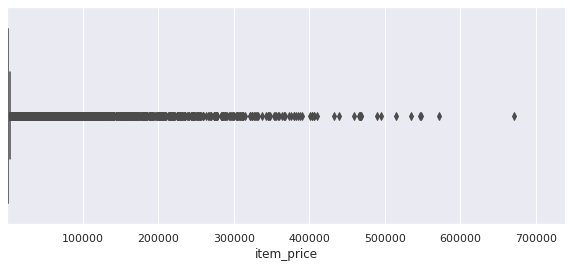

In [8]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train_monthly_agg.item_cnt)

plt.figure(figsize=(10,4))
plt.xlim(train_monthly_agg.item_price.min(), train_monthly_agg.item_price.max()*1.1)
sns.boxplot(x=train_monthly_agg.item_price)

In [9]:
train_monthly_agg = train_monthly_agg.query('item_price<400001 and item_cnt<1001')

In [10]:
train_monthly_agg['item_price_unit'] = train_monthly_agg['item_price'] // train_monthly_agg['item_cnt']
train_monthly_agg['item_price_unit'].fillna(0, inplace=True)

Lag between items from previous months

In [11]:
lag_list = [1, 2, 3]

for lag in lag_list:
    train_monthly_agg[f'item_cnt_shifted_{lag}'] = train_monthly_agg.sort_values('date_block_num').groupby(['shop_id', 'item_id', 'city_code', 'type_code', 'subtype_code'])['item_cnt'].shift(lag)
    train_monthly_agg[f'item_cnt_shifted_{lag}'].fillna(0, inplace=True)

In [12]:
train_monthly_agg.describe().T

,count,mean,std,min,25%,50%,75%,max
index,1608194.00,804108.06,464256.09,0.00,402048.25,804109.50,1206162.75,1608225.00
date_block_num,1608194.00,14.66,9.54,0.00,6.00,14.00,23.00,33.00
shop_id,1608194.00,32.81,16.54,0.00,21.00,31.00,47.00,59.00
item_id,1608194.00,10681.48,6238.88,0.00,5046.00,10497.00,16060.00,22169.00
city_code,1608194.00,16.11,7.67,0.00,13.00,13.00,23.00,30.00
type_code,1608194.00,10.28,3.36,0.00,8.00,11.00,13.00,19.00
subtype_code,1608194.00,17.93,19.65,0.00,2.00,10.00,32.00,64.00
item_price,1608194.00,1613.07,5399.27,0.09,249.00,499.00,1398.00,390830.00
mean_item_price,1608194.00,789.84,1547.00,0.09,199.00,399.00,894.00,307980.00
item_cnt,1608194.00,2.26,7.90,1.00,1.00,1.00,2.00,1000.00


### Use last 6 months as validation data and first 28 months as training data

In [13]:
train_set = train_monthly_agg.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly_agg.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly_agg.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt'], inplace=True)
validation_set.dropna(subset=['item_cnt'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

In [14]:
X_train = train_set.drop(['item_cnt', 'date_block_num', 'index'], axis=1)
Y_train = train_set['item_cnt'].astype(int)
X_validation = validation_set.drop(['item_cnt', 'date_block_num', 'index'], axis=1)
Y_validation = validation_set['item_cnt'].astype(int)

In [15]:
X_train.head()

,shop_id,item_id,city_code,type_code,subtype_code,item_price,mean_item_price,mean_item_cnt,year,month,item_price_unit,item_cnt_shifted_1,item_cnt_shifted_2,item_cnt_shifted_3
187032,2,31,0,11,1,699.00,699.00,1.00,2013,3,699.00,1.00,4.00,0.00
187033,2,464,0,12,39,299.00,299.00,1.00,2013,3,299.00,0.00,0.00,0.00
187034,2,482,0,15,0,3300.00,3300.00,1.00,2013,3,3300.00,1.00,1.00,1.00
187035,2,484,0,15,0,900.00,300.00,1.00,2013,3,300.00,2.00,4.00,2.00
187036,2,485,0,15,0,600.00,300.00,1.00,2013,3,300.00,0.00,0.00,0.00


In [16]:
category_features = ['shop_id', 'item_id', 'type_code', 'subtype_code', 'city_code', 'year', 'month']
catboost_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.4,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=category_features,
    eval_set=(X_validation, Y_validation)
)

0:	learn: 6.3553618	test: 6.1164075	best: 6.1164075 (0)	total: 810ms	remaining: 6m 44s
50:	learn: 1.3980473	test: 1.7511355	best: 1.7511355 (50)	total: 33s	remaining: 4m 50s
100:	learn: 1.0096741	test: 1.4066543	best: 1.4066543 (100)	total: 1m 5s	remaining: 4m 17s
150:	learn: 0.8442942	test: 1.3044431	best: 1.3042969 (149)	total: 1m 38s	remaining: 3m 46s
200:	learn: 0.7389755	test: 1.2432829	best: 1.2432829 (200)	total: 2m 11s	remaining: 3m 15s
250:	learn: 0.6724912	test: 1.1992816	best: 1.1988877 (242)	total: 2m 43s	remaining: 2m 41s
300:	learn: 0.6239246	test: 1.1852481	best: 1.1828492 (288)	total: 3m 18s	remaining: 2m 10s
350:	learn: 0.5803567	test: 1.1591995	best: 1.1591995 (350)	total: 3m 52s	remaining: 1m 38s
400:	learn: 0.5442752	test: 1.1507794	best: 1.1505769 (387)	total: 4m 22s	remaining: 1m 4s
450:	learn: 0.5169265	test: 1.1353202	best: 1.1324512 (446)	total: 5m 6s	remaining: 33.3s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 1.132451169
bestIteration = 

In [17]:
catboost_model.get_params()

{'iterations': 500,
 'learning_rate': 0.4,
 'depth': 4,
 'loss_function': 'RMSE',
 'od_wait': 25,
 'od_type': 'Iter',
 'random_seed': 0,
 'verbose': 50,
 'max_ctr_complexity': 4}

In [18]:
feature_score = pd.DataFrame(catboost_model.get_feature_importance(
    Pool(X_train, label=Y_train,cat_features=category_features)), columns=['score'])
feature_score['feature'] = X_train.columns

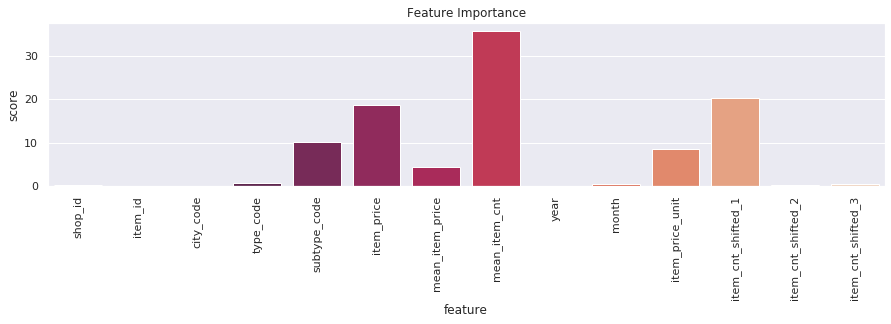

In [19]:
plt.figure(figsize=(15,3))
sns.barplot(x='feature', y='score', data=feature_score, palette="rocket").set_title("Feature Importance")
plt.xticks(rotation=90)
plt.show()